# Intro

In this notebook we will look at a South African house pricing index from 2001 until 2020. We will use time-series analysis to try to predict house prices in the future.

# Data Exploration
Lets first read in the data, explore it and plot it.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

            Index
Period           
2019-12-31  521.5
2020-01-31  521.1
2020-02-29  520.7
2020-03-31  520.7
2020-04-30  520.5


<AxesSubplot:xlabel='Period'>

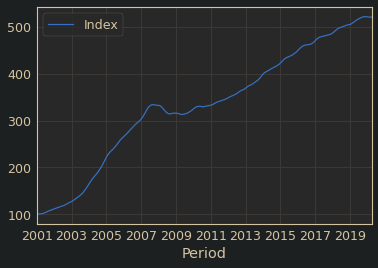

In [6]:
df = pd.read_csv('datasets/southafrica.csv')
df['Period'] = pd.to_datetime(df['Period'])
df = df.set_index('Period')
print(df.tail())
df.plot()

# Stationarity

Before we can use Vector AutoRegression we have to check for stationarity (i.e. mean and variance remain constant over time). 

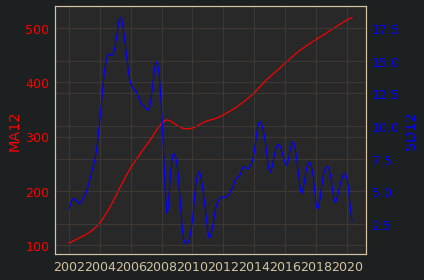

In [7]:
df_MA12 = df.rolling(12).mean()
df_SD12 = df.rolling(12).std()

def plot_twinx(series1, label1, series2, label2):
    fig, ax1 = plt.subplots()

    color = 'red'
    ax1.set_ylabel(label1, color=color)
    ax1.plot(series1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'blue'
    ax2.set_ylabel(label2, color=color)
    ax2.plot(series2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

plot_twinx(df_MA12, 'MA12', df_SD12, 'SD12')

On first sight, the series does not appear stationary. Let's check this with Dickey-Fuller.

In [8]:
from statsmodels.tsa.stattools import adfuller
def df_test(series):
    df_test = adfuller(series)
    index = ['Test statistic', 'P-value', '# of lags used', '# of observations used']
    df_out = pd.Series(df_test[0:4], index=index)
    for key, value in df_test[4].items():
        df_out['Critial value (%s)' % key] = value
    return df_out

df_test(df['Index'])

Test statistic             -1.803703
P-value                     0.378625
# of lags used              3.000000
# of observations used    228.000000
Critial value (1%)         -3.459361
Critial value (5%)         -2.874302
Critial value (10%)        -2.573571
dtype: float64

The Dickey-Fuller test confirms that the series is not stationary:
- P-value > 0.05 & Test statistic > Critical value (10%)
- We cannot reject the null-hypothesis of non-stationarity

Let's take the log of the series and the first difference and test again.

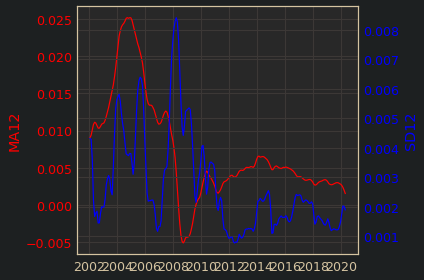

Test statistic             -1.802501
P-value                     0.379221
# of lags used              4.000000
# of observations used    226.000000
Critial value (1%)         -3.459620
Critial value (5%)         -2.874415
Critial value (10%)        -2.573632
dtype: float64

In [9]:
df_log = np.log(df)
df_log_dif = df_log.diff().dropna()

df_MA12 = df_log_dif.rolling(12).mean()
df_SD12 = df_log_dif.rolling(12).std()

plot_twinx(df_MA12, 'MA12', df_SD12, 'SD12')
df_test(df_log_dif)

On first sight, it seems that, even after taking the log and first difference the series is still not stationary. This is confirmed by the Dickey-Fuller test.

Let's try taking the second difference and test again.

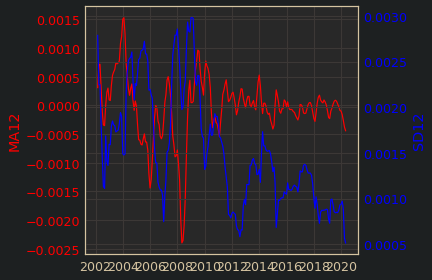

Test statistic           -8.882091e+00
P-value                   1.309611e-14
# of lags used            3.000000e+00
# of observations used    2.260000e+02
Critial value (1%)       -3.459620e+00
Critial value (5%)       -2.874415e+00
Critial value (10%)      -2.573632e+00
dtype: float64

In [10]:
df_log_dif2 = df_log_dif.diff().dropna()

df_MA12 = df_log_dif2.rolling(12).mean()
df_SD12 = df_log_dif2.rolling(12).std()

plot_twinx(df_MA12, 'MA12', df_SD12, 'SD12')
df_test(df_log_dif2)

The series is stationary after taking the log and second diff.

# Hyperparameter selection

To do an ARIMA analysis we will need to provide certain hyperparameters:
- p = The auto-regressive part of the model
- q = The moving average part of the model
- d = The amount of differencing needed

We already know that second differencing is necessary to make the series stationary. Let's now plot the Partial Autocorrelation Function (PACF) and Autocorrelation Function (ACF) to get a rough idea about the p and q values.

<function matplotlib.pyplot.show(close=None, block=None)>

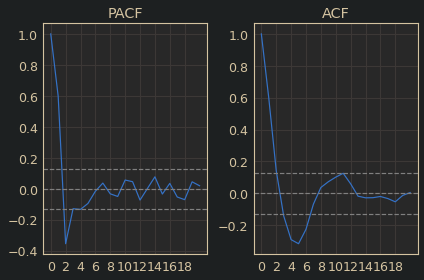

In [11]:
from statsmodels.tsa.stattools import pacf, acf
pacf = pacf(df_log_dif2, nlags=20, method='ols')
acf = acf(df_log_dif2, nlags=20, fft=False)

plt.subplot(121)
plt.plot(pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.xticks(ticks=np.arange(20, step=2))
plt.title('PACF')
plt.tight_layout()

plt.subplot(122)
plt.plot(acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.xticks(ticks=np.arange(20, step=2))
plt.title('ACF')
plt.tight_layout()

plt.show

The PACF and ACf seem to suggest an ideal p=1 and q=2 for the ARIMA model. Let's test over a couple of ranges to test which one gives the best result:
- p = [0, 1, 2, 3]
- q = [0, 1, 2, 3]
- d = 2

As we want to take into account the seasonality of the series we will also have to provide a P, Q, D and m. We will test over the following ranges:
- P = [0, 1, 2]
- Q = [0, 1, 2]
- D = [0, 2]
- m = 12

In [12]:
import pmdarima as pm
model = pm.auto_arima(df_log, d=2, start_p=0, max_p=3, start_q=0, max_q=3, m=12, D=None, max_D=2, start_P=0, max_P=2, start_Q=0, max_Q=2, test='adf', trace=True, error_action='ignore', method='Powell')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-2271.603, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-2373.519, Time=0.16 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-2377.081, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-2378.488, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-2376.972, Time=0.16 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-2375.459, Time=0.24 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=-2395.076, Time=0.13 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-2393.295, Time=0.28 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=-2393.313, Time=0.28 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=-2391.452, Time=0.40 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-2375.351, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=-2412.752, Time=0.12 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-2410.853, Time=0.33 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=-2410.851, Time=0.34 sec
 ARIM

The best model according to pmdarima is: ARIMA(2,2,1)(0,0,0)[12]

# Exercise 5

In [198]:
from statsmodels.tsa.arima.model import ARIMA
df.index.freq = 'M'
model = ARIMA(df_log, order=(2,2,1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Index   No. Observations:                  232
Model:                 ARIMA(2, 2, 1)   Log Likelihood                1208.596
Date:                Sat, 19 Dec 2020   AIC                          -2409.192
Time:                        10:05:44   BIC                          -2395.440
Sample:                    01-31-2001   HQIC                         -2403.644
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1267      0.141      7.989      0.000       0.850       1.403
ar.L2         -0.5051      0.082     -6.140      0.000      -0.666      -0.344
ma.L1         -0.3624      0.170     -2.127      0.0

                   0
Period              
2001-01-31  4.605170
2001-02-28 -2.295609
2001-03-31 -0.004991
2001-04-30  0.002074
2001-05-31  0.004203


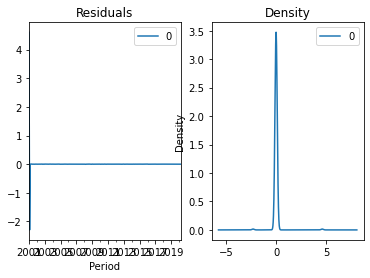

In [199]:
res = pd.DataFrame(result.resid)
print(res.head(5))

fig, ax = plt.subplots(1,2)
res.plot(title='Residuals', ax=ax[0])
res.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Exercise 6

# Exercise 7

In [200]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_log, order=(2,2,1), seasonal_order=(0,0,0, 0))
result = model.fit(method='Powell')

Optimization terminated successfully.
         Current function value: -5.217139
         Iterations: 3
         Function evaluations: 225


Index             mean   mean_se  mean_ci_lower  mean_ci_upper
2020-05-31  520.130971  1.001252     519.297807     520.965471
2020-06-30  519.670275  1.003668     517.237879     522.114111
2020-07-31  519.199056  1.007096     514.515589     523.925154
2020-08-31  518.773413  1.011194     511.424840     526.227576
2020-09-30  518.414295  1.015630     508.212268     528.821120
2020-10-31  518.112842  1.020169     505.022038     531.542977
2020-11-30  517.843905  1.024709     501.896059     534.298497
2020-12-31  517.580281  1.029250     498.805823     537.061388
2021-01-31  517.302629  1.033859     495.691675     539.855768
2021-02-28  517.003236  1.038623     492.494441     542.731701
2021-03-31  516.684524  1.043618     489.174019     545.742185
2021-04-30  516.354661  1.048889     485.715433     548.926631


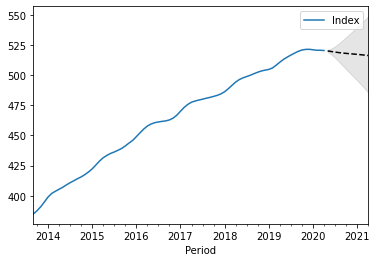

In [201]:
fcast = np.exp(result.get_forecast(steps=12).summary_frame(alpha=0.2))
print(fcast)

fig, ax = plt.subplots()
df[-80:].plot(ax=ax)
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.show()

# Exercise 8

In [202]:
obs = 200
forecasts = {}
for t in range(obs,len(df_log)):
    model = SARIMAX(df_log[:t], order=(2,2,1), seasonal_order=(0,0,0, 0))
    result = model.fit(method='Powell')
    fcast = np.exp(result.forecast())[0]
    forecasts[df.index[t]] = fcast

Optimization terminated successfully.
         Current function value: -5.149727
         Iterations: 3
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: -5.151871
         Iterations: 3
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -5.154542
         Iterations: 3
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -5.157271
         Iterations: 3
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: -5.159712
         Iterations: 3
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -5.161508
         Iterations: 3
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -5.163592
         Iterations: 3
         Function evaluations: 238
Optimization terminated suc

In [203]:
forecasts.values()

dict_values([481.91861392611685, 482.2815779160182, 483.3311450869696, 484.28493885276043, 485.9098739771686, 488.47788510402506, 491.6561945096869, 494.3718998085953, 496.7131694704274, 497.95062062630166, 498.7558187430581, 499.9845836036011, 501.2891649045825, 502.8599637462866, 503.6400357493949, 504.3805609443085, 504.7375935700315, 505.4297714938887, 507.73847158256507, 511.3517722154585, 513.1491346941508, 515.0337016885716, 516.5249915346064, 518.3035154981411, 519.9032017292407, 521.2936059656236, 521.7602992100221, 521.5749540554755, 521.5083903026341, 520.5319036466675, 520.5308686413446, 521.1309109837119])

In [204]:
result_df = pd.DataFrame.from_dict(forecasts, orient='index', columns=['Forecasts'])
result_df = pd.concat([df, result_df], axis=1).dropna()
result_df['SqEr'] = (result_df['Forecasts']-result_df['Index'])**2
RMSE = np.sqrt(result_df['SqEr'].mean())
print(RMSE)

0.28812161097970795


# Exercise 9

In [205]:
obs = 200
hor = 4
forecasts = {}
gtruths = {}

for t in range(obs,len(df_log) - hor + 1):
    model = SARIMAX(df_log[:t], order=(2,2,1), seasonal_order=(0,0,0, 0))
    result = model.fit(method='Powell')
    fcast = result.forecast(hor)
    forecasts[df.index[t]] = np.exp(fcast)
    gtruths[df.index[t]] = df.reindex(fcast.index)

Optimization terminated successfully.
         Current function value: -5.149727
         Iterations: 3
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: -5.151871
         Iterations: 3
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -5.154542
         Iterations: 3
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -5.157271
         Iterations: 3
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: -5.159712
         Iterations: 3
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -5.161508
         Iterations: 3
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -5.163592
         Iterations: 3
         Function evaluations: 238
Optimization terminated suc

In [206]:
forecasts = pd.concat(forecasts, axis=1)
gtruths = pd.concat(gtruths, axis=1)
gtruths.columns = forecasts.columns

rmse = np.sqrt(((forecasts - gtruths)**2).mean().mean())
print(rmse)

1.6632745052518692


# Exercise 10

/home/mdc/.local/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


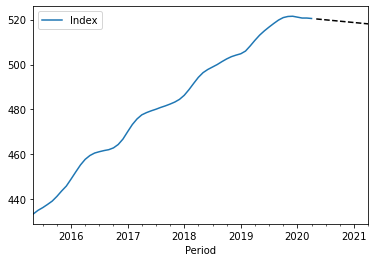

In [207]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df_log, trend='mul')
result = model.fit()

fcast = np.exp(result.forecast(12))

fig, ax = plt.subplots()
df[-60:].plot(ax=ax)
fcast.plot(ax=ax, style='k--')
plt.show()